In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_feather("/kaggle/input/kaggle-dataset/nvda.feature")
df.head()

,Adj Close,Close,High,Low,Open,Volume,Log Return,LOG_FD
Date,,,,,,,,
2018-03-27 00:00:00+00:00,5.580910,5.63800,6.25000,5.49625,6.19375,1409000000,-0.080725,-0.064368
2018-03-28 00:00:00+00:00,5.477717,5.53375,5.73475,5.42500,5.60325,945904000,-0.018663,-0.018959
2018-03-29 00:00:00+00:00,5.731123,5.78975,5.88750,5.51750,5.60275,916628000,0.045223,0.046902
2018-04-02 00:00:00+00:00,5.470291,5.52625,5.86625,5.43750,5.71850,922092000,-0.046580,-0.033329
2018-04-03 00:00:00+00:00,5.576703,5.63375,5.75875,5.53375,5.69500,667432000,0.019266,0.022487


# Step 3

In this section, we are going to use a Convolutional Neural Network (CNN) to predict the evolution of stock features in the future.

To perform CNN on our time series data, we first need to use the Gramian Angular Field (GAF) to transform the data into images. The dataset is built based on a 30-day time series. After applying GAF, we also rescale the data so that the values lie within the unit interval (between 0 and 1). The label indicates whether the time series increased or decreased over the following 7 days.

Because our dataset is limited, and to avoid overfitting, we will build a simple CNN model with the following structure:

- Input layer: Reads the data as a 3-dimensional tensor of shape 30x30x1.
- First Convolutional layer: Has 8 output channels and kernels of size 2x2. After applying convolution, we use a ReLU activation function and then a 2x2 max-pooling layer.
- Second Convolutional layer: Has 16 output channels and kernels of size 2x2. After applying convolution, we use a ReLU activation function and then a 2x2 max-pooling layer.
- Flatten layer: Reshapes the data into a 1-dimensional tensor.
- Fully connected layer: Contains 10 units, uses a ReLU activation function, and applies a dropout rate of 0.5.
- Output layer: A single neuron with a sigmoid activation function, representing the probability of the label.

To train the model, we compile it using the Adam optimizer with learning rate of 0.001 and binary cross-entropy loss as the objective function. There is no need to adjust the class weights because our dataset is fairly balanced between the two labels.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

try:
    from pyts.image import GramianAngularField
except:
    !pip install pyts --quiet
    from pyts.image import GramianAngularField

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
def create_data(df, feature , window_size=30, predict_window=7):
    Xdf = df[feature].copy()
    # Create X
    X_train = []
    for i in range(window_size, df.shape[0]):
        X_train.append(Xdf[i - window_size : i])
    X_train = np.array(X_train)

    # Transform to image using GAF
    transformer = GramianAngularField()
    X_train_new = transformer.transform(X_train)

    # Determine the examples to be used as inputs in the model and rescale them to the [0,1] scale
    X_data = X_train_new[:-predict_window]
    for i in range(X_data.shape[0]):
        X_data[i] = (X_data[i] - np.min(X_data[i])) / (
            np.max(X_data[i]) - np.min(X_data[i])
        )

    # Generate the labels: 1 if price goes up after predict_window days, 0 otherwise
    y_data = []
    for i in range(window_size, Xdf.shape[0] - predict_window):
        y_data.append(Xdf[i] < Xdf[i + predict_window])
    y_data = np.array(y_data)

    
    return X_data, y_data
    

def train_cnn_model(X_train, X_test, y_train, y_test ):
    # Define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    
    model.add(tf.keras.layers.Conv2D(8, 2, activation="relu"))    
    model.add(tf.keras.layers.MaxPooling2D(2))
    
    model.add(tf.keras.layers.Conv2D(16, 2, activation="relu"))    
    model.add(tf.keras.layers.MaxPooling2D(2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5, seed=1234))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile model 
    model.compile(loss="binary_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                  metrics=["accuracy"])
    

    # Fit model
    model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test),
        epochs=50,
    )

    return model

def evaluation_model(model, X_data,y_data):
    y_prob = model.predict(X_data)
    y_pred = np.round(y_prob)
    cm = metrics.confusion_matrix(y_data, y_pred)
    cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
    cm.plot(values_format="", cmap="Blues")
    print(classification_report(y_data, y_pred))
    

# a. Raw data

By performing the GAF transformation, we generated 1,635 images, each with a size of 30x30 pixels and a single channel, from the daily adjusted close prices of NVDA.

Then, we split the data into 2 sets:

- Training set: Used to train the parameters of the model.
- Test set: Used for evaluation.

In [5]:
X_raw, y_raw = create_data(df, feature = "Adj Close" , window_size=30, predict_window=7)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, train_size = 0.8, shuffle=False)
print(X_raw.shape, y_raw.shape)

(1635, 30, 30) (1635,)


In [6]:
tf.random.set_seed(1234)
model_for_raw = train_cnn_model(X_train_raw, X_test_raw, y_train_raw, y_test_raw)

Epoch 1/50


I0000 00:00:1731943963.561565     113 service.cc:145] XLA service 0x795d8c005630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731943963.561627     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731943963.561634     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


25/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5743 - loss: 0.6872 

I0000 00:00:1731943967.174814     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.5783 - loss: 0.6865 - val_accuracy: 0.6239 - val_loss: 0.6729
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6061 - loss: 0.6795 - val_accuracy: 0.6239 - val_loss: 0.6733
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6051 - loss: 0.6730 - val_accuracy: 0.6239 - val_loss: 0.6775
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5962 - loss: 0.6755 - val_accuracy: 0.6239 - val_loss: 0.6793
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6027 - loss: 0.6700 - val_accuracy: 0.6239 - val_loss: 0.6815
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6113 - loss: 0.6733 - val_accuracy: 0.6239 - val_loss: 0.6841
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6066 - loss: 0.6679 - val_accuracy: 0.5810 - val_loss: 0.6921
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6019 - loss: 0.6689 - val_accuracy: 0.6239 - val_loss: 0.6877
Ep

In [7]:
model_for_raw.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 29, 29, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,049 (74.41 KB)

 Trainable params: 6,349 (24.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,700 (49.61 KB)

Performance of model on training data
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

       False       0.69      0.74      0.72       538
        True       0.81      0.77      0.79       770

    accuracy                           0.76      1308
   macro avg       0.75      0.76      0.75      1308
weighted avg       0.76      0.76      0.76      1308



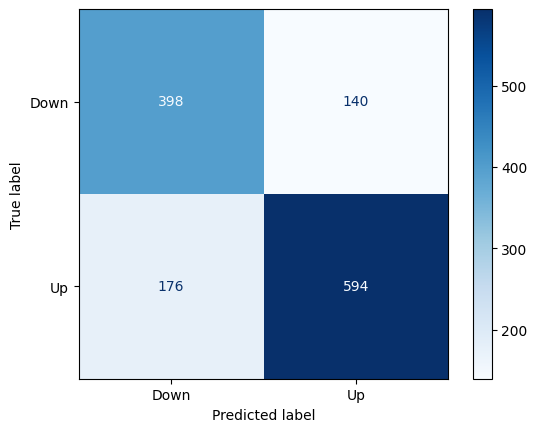

In [8]:
print("Performance of model on training data")
evaluation_model(model_for_raw, X_train_raw, y_train_raw)

Performance of model on testing data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

       False       0.30      0.30      0.30       123
        True       0.58      0.58      0.58       204

    accuracy                           0.48       327
   macro avg       0.44      0.44      0.44       327
weighted avg       0.48      0.48      0.48       327



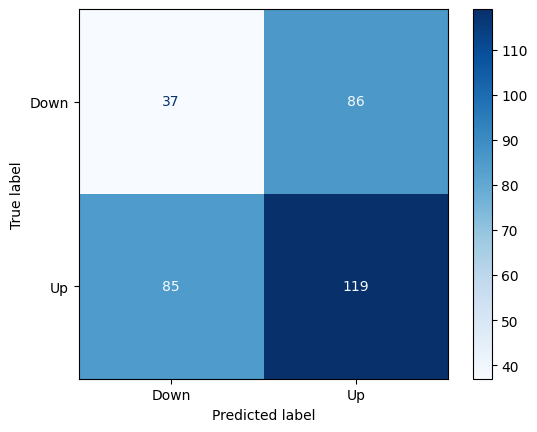

In [9]:
print("Performance of model on testing data")
evaluation_model(model_for_raw, X_test_raw, y_test_raw)

The CNN model trained on stock prices achieved an accuracy of 47%. All performance metrics on the testing set, including accuracy, precision, recall, and F1-score, were worse than those on the training set. This indicates overfitting, which can be partly explained by the fact that the number of observations is much smaller than the number of parameters in the model.

## b. Stationary data

By performing the GAF transformation, we generated 1,635 images, each with a size of 30x30 pixels and a single channel, from the daily log returns of NVDA.

Then, we also split the data into 2 sets:

- Training set: Used to train the parameters of the model.
- Test set: Used for evaluation.

In [10]:
X_stat, y_stat = create_data(df, feature = "Log Return" ,  window_size=30, predict_window=7)
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, train_size = 0.8, shuffle=False)
print(X_stat.shape, y_stat.shape)

(1635, 30, 30) (1635,)


In [11]:
tf.random.set_seed(1234)
model_for_stat = train_cnn_model(X_train_stat, X_test_stat, y_train_stat, y_test_stat)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5000 - loss: 0.6938 - val_accuracy: 0.4648 - val_loss: 0.6934
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4822 - loss: 0.6934 - val_accuracy: 0.4679 - val_loss: 0.6933
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4896 - loss: 0.6930 - val_accuracy: 0.4740 - val_loss: 0.6938
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4918 - loss: 0.6932 - val_accuracy: 0.4709 - val_loss: 0.6937
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5252 - loss: 0.6927 - val_accuracy: 0.4771 - val_loss: 0.6938
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 0.6908 - val_accuracy: 0.4709 - val_loss: 0.6939
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5217 - loss: 0.6915 - val_accuracy: 0.4893 - val_loss: 0.6943
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5288 - loss: 0.6921 - val_accuracy: 0.4618 - val_loss

In [12]:
model_for_stat.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,049 (74.41 KB)

 Trainable params: 6,349 (24.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,700 (49.61 KB)

Performance of model on training data
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

       False       0.79      0.80      0.80       655
        True       0.80      0.79      0.79       653

    accuracy                           0.79      1308
   macro avg       0.79      0.79      0.79      1308
weighted avg       0.79      0.79      0.79      1308



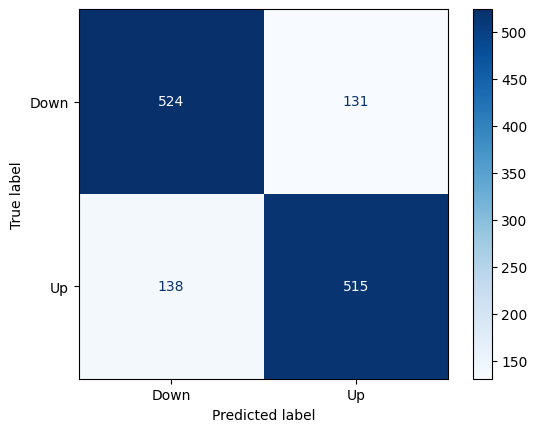

In [13]:
print("Performance of model on training data")
evaluation_model(model_for_stat, X_train_stat, y_train_stat)

Performance of model on testing data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

       False       0.51      0.52      0.51       166
        True       0.50      0.49      0.49       161

    accuracy                           0.50       327
   macro avg       0.50      0.50      0.50       327
weighted avg       0.50      0.50      0.50       327



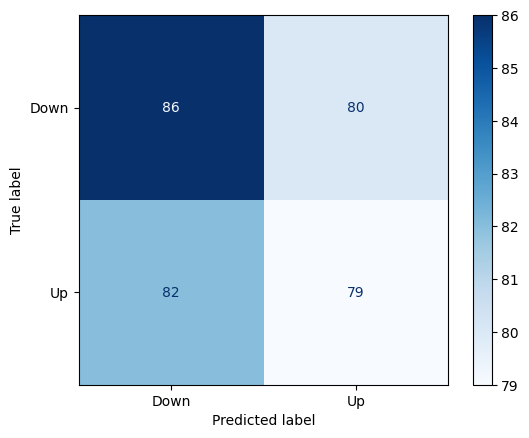

In [14]:
print("Performance of model on testing data")
evaluation_model(model_for_stat, X_test_stat, y_test_stat)

The CNN model trained on daily log ruturn achieved an accuracy of 50%. For a stationary dataset, all performance metrics on the testing set, including accuracy, precision, recall, and F1-score, were still much worse than those on the training set. This indicates overfitting, which can be partly explained by the fact that the number of observations is much smaller than the number of parameters in the model.

## Tune model

To address overfitting, now we are going to perform model fine tuning. 

First we need to split our data into 3 sets:

- Training set: used to train parameters in model
- Validation set: used to train the hyperparameters to choose the best model
- Test set: used to evaluate our final model

Here, we are tuning 3 hyper-parameters:

- **Dropout**e tuner choose between a value for dropout of 0.2 or 0.
- **Number of Convolutional layers in the model**: tuner choose between 1 and 3 hidden layers in the model.
- **Number of output layer in each Convolutional layers**: tuner choose between 8 (min_value) and 32 (max_value) units in each layer, with a step size of 16.
- **Kernel size in each Convolutional layers**: tuner choose between 2 or 3 
- **Pooling kernel size after Convolutional layers**: tuner choose between 2 or 3 3.
- **Number Dense of layers in the mo**: he tuner choose between 1 a3d 5 hidden layers in the modod.
- **Number of units in each hidden layer**: the tuner will choose betw8en 1 (min_value) 32d 25 (max_value) units in each layer, with a step size8o
- **Learning rate**: the tuner will choose between 8 (min_value) and 32 (max_value) f 5.



In [15]:

def split_dataset(X_data, y_data, train_size=0.85):
    X_train_all, X_test, y_train_all, y_test = train_test_split(X_data, y_data, train_size = train_size, shuffle=False)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, train_size = train_size, shuffle=False)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


In [29]:
import keras_tuner as kt 
import tensorflow as tf 
from keras_tuner import HyperModel
from kerastuner import RandomSearch

class CNN_model(HyperModel):
    def build(self, hp):
        act_fun = "relu"
        n_dropout = hp.Choice("n_dropout", values=[0.2, 0.3])
        n_pool = hp.Choice("n_pool", values=[2, 3])

        # Create model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))

        # Add CNN layer
        for i in range(1, hp.Int("conv_num_layers", 1, 3)):
            model.add(tf.keras.layers.Conv2D(
                filters=hp.Int('conv_filter_' + str(i), min_value=8, max_value=32, step=16),
                kernel_size=hp.Choice('conv_kernel_' + str(i), values = [2,3]),
                activation=act_fun))  
            model.add(tf.keras.layers.MaxPooling2D(n_pool))
        
        model.add(tf.keras.layers.Flatten())       
        for j in range(1, hp.Int("dense_num_layers", 1, 3)):   
            model.add(tf.keras.layers.Dense(
                    units=hp.Int("dense_units_" + str(j), min_value=8, max_value=32, step=8),
                    activation=act_fun,))
            model.add(tf.keras.layers.Dropout(n_dropout))

        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

        
        # Compile model 
        hp_lr =  hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        #hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        model.compile(loss="binary_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), 
                  metrics=["accuracy"])

        return model

def tuning_model(mod, X_train, X_valid, y_train, y_valid, tuner_method = "RandomSearch"):
    
    if tuner_method == "RandomSearch":
        tuner = RandomSearch(mod,
                        objective=kt.Objective("val_loss", direction="min"),
                        seed=1234,
                         max_trials = 30,
                         overwrite=True,)
    else:
        tuner = kt.Hyperband(
            mod,
            objective=kt.Objective("val_loss", direction="min"), 
            overwrite=True, # overwrite results
            max_epochs=30,
            seed=1234,)
        
    
    
    tuner.search(
        X_train, 
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=30)

    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    model = tuner.hypermodel.build(best_hps) # already compile optimization and loss 

    
    # fit the model
    model.fit(
        np.concatenate((X_train, X_valid)),
        np.concatenate((y_train, y_valid)),
        epochs=30,
        batch_size=32,
        verbose=2,
    )

    return model, best_hps.values


    

In [30]:
X_raw, y_raw = create_data(df, feature = "Adj Close" , window_size=30, predict_window=7)
X_train_raw, X_valid_raw, X_test_raw, y_train_raw, y_valid_raw, y_test_raw = split_dataset(X_raw, y_raw, train_size = 0.8)

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
hypermodel_raw = CNN_model()
bestmodel_raw, besthyper_raw = tuning_model(hypermodel_raw, X_train_raw, X_valid_raw, y_train_raw, y_valid_raw)


Trial 30 Complete [00h 00m 13s]
val_loss: 0.6566534638404846

Best val_loss So Far: 0.6432269215583801
Total elapsed time: 00h 04m 33s
Epoch 1/30
41/41 - 6s - 147ms/step - accuracy: 0.5573 - loss: 0.7049
Epoch 2/30
41/41 - 0s - 2ms/step - accuracy: 0.5818 - loss: 0.6807
Epoch 3/30
41/41 - 0s - 2ms/step - accuracy: 0.5956 - loss: 0.6720
Epoch 4/30
41/41 - 0s - 2ms/step - accuracy: 0.5956 - loss: 0.6681
Epoch 5/30
41/41 - 0s - 2ms/step - accuracy: 0.5887 - loss: 0.6677
Epoch 6/30
41/41 - 0s - 2ms/step - accuracy: 0.6154 - loss: 0.6614
Epoch 7/30
41/41 - 0s - 2ms/step - accuracy: 0.6323 - loss: 0.6469
Epoch 8/30
41/41 - 0s - 2ms/step - accuracy: 0.6460 - loss: 0.6365
Epoch 9/30
41/41 - 0s - 2ms/step - accuracy: 0.6162 - loss: 0.6498
Epoch 10/30
41/41 - 0s - 2ms/step - accuracy: 0.6353 - loss: 0.6387
Epoch 11/30
41/41 - 0s - 2ms/step - accuracy: 0.6300 - loss: 0.6332
Epoch 12/30
41/41 - 0s - 2ms/step - accuracy: 0.6498 - loss: 0.6215
Epoch 13/30
41/41 - 0s - 2ms/step - accuracy: 0.6476 - l

In [32]:
print("Best Hyperparameters: ", besthyper_raw)
print(bestmodel_raw.summary())

Best Hyperparameters:  {'n_dropout': 0.2, 'n_pool': 2, 'conv_num_layers': 1, 'dense_num_layers': 3, 'lr': 0.004466113174576286, 'conv_filter_1': 8, 'conv_kernel_1': 3, 'dense_units_1': 32, 'conv_filter_2': 8, 'conv_kernel_2': 2, 'dense_units_2': 32}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,765 (350.65 KB)

 Trainable params: 29,921 (116.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,844 (233.77 KB)

None


Performance of model on testing data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

       False       0.35      0.26      0.30       123
        True       0.61      0.71      0.66       204

    accuracy                           0.54       327
   macro avg       0.48      0.49      0.48       327
weighted avg       0.52      0.54      0.52       327



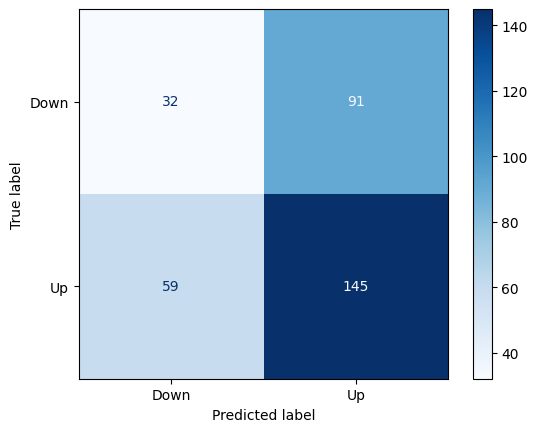

In [33]:
print("Performance of model on testing data")
evaluation_model(bestmodel_raw, X_test_raw, y_test_raw)

We can see the performance of model does not improve much. Sometimes, the best model after tuning does not include the Convolution layers.

In [34]:
X_stat, y_stat = create_data(df, feature = "Log Return" ,  window_size=30, predict_window=7)
X_train_stat, X_valid_stat, X_test_stat, y_train_stat, y_valid_stat, y_test_stat = split_dataset(X_stat, y_stat, train_size = 0.8)


In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
hypermodel_stat = CNN_model()
bestmodel_stat, besthyper_stat = tuning_model(hypermodel_stat, X_train_stat, X_valid_stat, y_train_stat, y_valid_stat )


Trial 30 Complete [00h 00m 13s]
val_loss: 0.6932933926582336

Best val_loss So Far: 0.6831860542297363
Total elapsed time: 00h 04m 45s
Epoch 1/30
41/41 - 2s - 41ms/step - accuracy: 0.4985 - loss: 0.7003
Epoch 2/30
41/41 - 0s - 2ms/step - accuracy: 0.5145 - loss: 0.6928
Epoch 3/30
41/41 - 0s - 2ms/step - accuracy: 0.5352 - loss: 0.6897
Epoch 4/30
41/41 - 0s - 3ms/step - accuracy: 0.5466 - loss: 0.6871
Epoch 5/30
41/41 - 0s - 2ms/step - accuracy: 0.5505 - loss: 0.6851
Epoch 6/30
41/41 - 0s - 2ms/step - accuracy: 0.5604 - loss: 0.6832
Epoch 7/30
41/41 - 0s - 3ms/step - accuracy: 0.5673 - loss: 0.6815
Epoch 8/30
41/41 - 0s - 2ms/step - accuracy: 0.5696 - loss: 0.6798
Epoch 9/30
41/41 - 0s - 2ms/step - accuracy: 0.5726 - loss: 0.6781
Epoch 10/30
41/41 - 0s - 2ms/step - accuracy: 0.5803 - loss: 0.6762
Epoch 11/30
41/41 - 0s - 2ms/step - accuracy: 0.5894 - loss: 0.6743
Epoch 12/30
41/41 - 0s - 3ms/step - accuracy: 0.5902 - loss: 0.6722
Epoch 13/30
41/41 - 0s - 2ms/step - accuracy: 0.5986 - lo

In [36]:
print("Best Hyperparameters: ", besthyper_stat)
print(bestmodel_stat.summary())

Best Hyperparameters:  {'n_dropout': 0.2, 'n_pool': 2, 'conv_num_layers': 2, 'dense_num_layers': 1, 'lr': 0.0015929086245058178, 'conv_filter_1': 8, 'conv_kernel_1': 2, 'dense_units_1': 32, 'conv_filter_2': 24, 'conv_kernel_2': 3, 'dense_units_2': 16}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829 (18.87 KB)

 Trainable params: 1,609 (6.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,220 (12.58 KB)

None


Performance of model on testing data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

       False       0.50      0.61      0.55       166
        True       0.47      0.35      0.40       161

    accuracy                           0.49       327
   macro avg       0.48      0.48      0.48       327
weighted avg       0.48      0.49      0.48       327



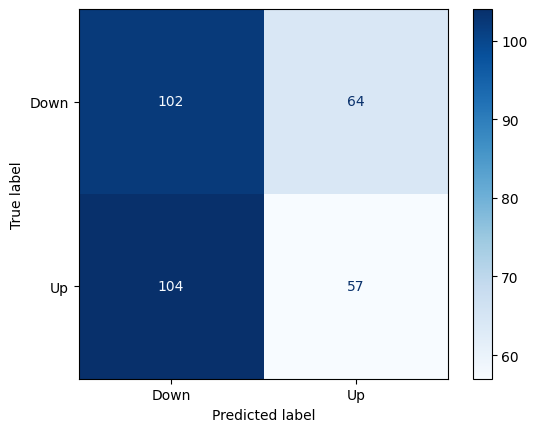

In [37]:
print("Performance of model on testing data")
evaluation_model(bestmodel_stat, X_test_stat, y_test_stat)

We can see the performance of model does not improve much with stationary data as well. Sometimes, the best model after tuning does not include the Convolution layers.

Therefore, we can conclude that Convolutional model does not perform well on our data, at least for the chosen period.